In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time
from PIL import Image

## generating input data

In [2]:
x = np.linspace(0,1,100)

## oscillator values 

In [3]:
def get_wave_y(x, d, w0):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

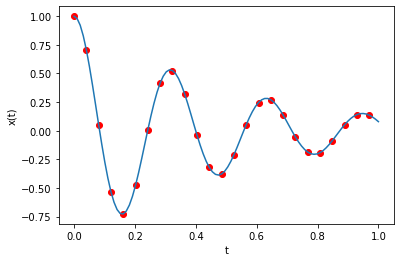

In [4]:
d,w0 =2,20
y = get_wave_y(x,d=2,w0=20)
x_data = x[0::4]
y_data = y[0::4]
plt.plot(x,y)
plt.scatter(x_data, y_data, c='red')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

In [5]:
x_data.shape

(25,)

In [6]:
x_new = x.reshape(-1,1)
y_new = y.reshape(-1,1)
x_data_new = x.reshape(-1,1)
y_data_new = y.reshape(-1,1)
x_new.shape

(100, 1)

```plt.plot()``` works for both (n,) numpy arrays and (n,1) numpy arrays (obtained using ```reshape(-1,1)```)

(n,1) array is for tensorflow/keras NN model

## keras NN model 
* optimizer  = RMSprop
* loss       = MeanSquaredError
* activation = tanh

In [132]:
nodes = 20
model = keras.Sequential([
    keras.layers.Dense(nodes,activation=keras.activations.tanh,input_shape=(1,)),
    keras.layers.Dense(nodes,activation=keras.activations.tanh),
    keras.layers.Dense(1,activation=keras.activations.tanh)
])
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
#     loss=keras.losses.MeanSquaredError(),
    loss=total_loss2,
#     metrics=['accuracy']
)
# model.summary()

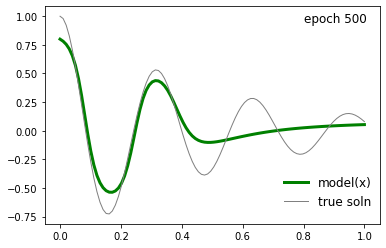

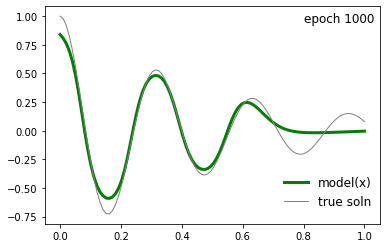

In [133]:
# start = time.time()
epochs = 1000
files = []
for i in range(epochs):
    model.fit(x_data,y_data,verbose=0, epochs=1)
    progress_bar(i+1,epochs, 'epoch ')
    plot_curve(x,y,model(x))
    
    files.append(f"images/{i:004}.png")
    plt.savefig(f'images/{i:004}', dpi=100, facecolor='white')
    if (i+1)%(epochs//2) == 0:
        plt.show()
    else:
        plt.close()

In [130]:
img = [Image.open(file) for file in files]
img[0].save(fp='wave_2_1.gif', format='GIF', append_images=img[1:], save_all=True, duration=0, loop=0)

In [30]:
model(x)[:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.81489056],
       [0.7779742 ],
       [0.72560424],
       [0.65215784],
       [0.5519997 ]], dtype=float32)>

In [119]:
def plot_curve(a,b,c):
    plt.plot(a,c,c='green', linewidth=3, label='model(x)')
    plt.plot(a,b,c='grey', linewidth=1, label='true soln')
    plt.legend(loc=(0.7,0.05), frameon=False, fontsize='large')
#     plt.axis('off')
    plt.text(0.8,0.95,f"epoch {i+1}",fontsize="large",color="k")

In [26]:
def progress_bar(progress, total, prompt=''):
    percent = (progress/float(total)) * 100
    bar = '#'*int(percent/2) + '-'*(50-int(percent/2))
    print(f"\r{prompt}{progress}/{total} |{bar}|  {percent:.1f}%", end='\r')

In [117]:
def new_plot():
    plt.plot(x,np.sin(x), label='model(x)')
    plt.plot(x,np.cos(x), label='true soln')
    plt.legend(loc=(0.7,0.05), frameon=False, fontsize='large')
#     plt.axis('off')
    plt.text(0.8,0.95,f"epoch {i+1}",fontsize="large",color="k")

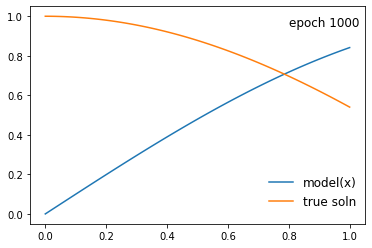

In [118]:
new_files = []
new_plot()
new_files.append(f"new_images/{2}.png")
plt.savefig(f"new_images/{2}", dpi=100)
# plt.close()

In [223]:
a = 12
print("%a"%(a**2))

144


In [ ]:
Image.save()


## notes
* you can create custom loss function in keras.losses
* special features
   * rmsprop to optimize loss function
   * loss function = (data loss) + (physics loss)
   

## keras NN model2

In [9]:
x_phys = tf.linspace(0,1,30)
x_data_tf = tf.constant(x_data)
y_data_tf = tf.constant(y_data)

In [10]:
x_phys

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ])>

In [138]:
def total_loss(y_true, y_pred):
    l1 = loss_1()
    l2 = loss_2()
    return l1 + l2
# total_loss()

In [11]:
def total_loss2(y_true, y_pred):
    sq = tf.square(y_true-y_pred)
    l_1 = tf.reduce_mean(sq)
    
    mu, k = d*2, w0**2
    with tf.GradientTape(persistent=True) as g:
        g.watch(x_phys)
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x_phys)
            y_phys = model(x_phys)
            
        dx = tf.cast(gg.gradient(y_phys,x_phys), dtype=tf.float32)
    dx2 = tf.cast(g.gradient(dx,x_phys), dtype=tf.float32)
    eqn = dx2 + mu*dx + k*tf.reshape(y_phys, [y_phys.shape[0],])
    l_2 = tf.cast((1e-6)*tf.reduce_mean(eqn**2), dtype=tf.float32)
    return l_1 + l_2
#     return eqn

total_loss2(y_data,model(x_data_tf))

<tf.Tensor: shape=(), dtype=float32, numpy=0.15670745>

In [15]:
def loss_2(y_true, y_pred):
    mu, k = d*2, w0**2
    with tf.GradientTape(persistent=True) as g:
        g.watch(x_data_tf)
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x_data_tf)
            y_phys = model2(x_data_tf)
            
        dx = tf.cast(gg.gradient(y_phys,x_data_tf), dtype=tf.float32)
    dx2 = tf.cast(g.gradient(dx,x_data_tf), dtype=tf.float32)
#     eqn = dx2 + mu*dx + k*y_phys.numpy().reshape(25,)
    eqn = dx2 + mu*dx + k*tf.reshape(y_phys, [25,])
    return tf.cast((1e-4)*tf.reduce_mean(eqn**2), dtype=tf.float32)
#     return eqn

In [34]:
def loss_1(y_true, y_pred):
    y_pred = model2(x_data_tf)
    sq = tf.square(y_data-y_pred)
#     print(sq.shape)
    return tf.reduce_mean(sq)

# loss_1()

In [35]:
nodes = 20
model2 = keras.Sequential([
    keras.layers.Dense(nodes,activation=keras.activations.tanh,input_shape=(1,)),
    keras.layers.Dense(nodes,activation=keras.activations.tanh),
    keras.layers.Dense(1,activation=keras.activations.tanh)
])
model2.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=loss_1,
    metrics=['accuracy']
)
# model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 20)                40        
                                                                 
 dense_19 (Dense)            (None, 20)                420       
                                                                 
 dense_20 (Dense)            (None, 1)                 21        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [36]:
# epochs = 1000
# for i in range(epochs):
model2.fit(x_data,y_data,verbose=0,epochs=10000)
#     progress_bar(i+1,epochs)

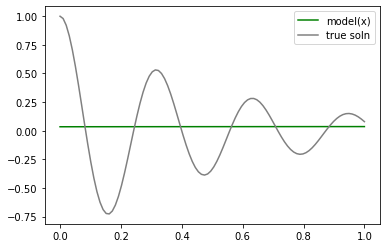

In [37]:
y_pred_2 = model2(x)
plt.plot(x,y_pred_2,c='green')
plt.plot(x,y,c='grey')
plt.legend(['model(x)','true soln'])

## Tensorflow/keras loss functions and classes

In [88]:
tf.print(keras.losses.mean_squared_error(tf.ones((1,4)), tf.zeros((1,4))))
# function version does not perform reduction

[1]


In [86]:
loss_fn1 = keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
loss_fn2 = keras.losses.MeanSquaredError(reduction='sum')
loss_fn3 = keras.losses.MeanSquaredError(reduction='none')

# loss_fn1(tf.ones((4,4)), tf.zeros((4,4)))      # avg of all per-sample losses
# loss_fn2(tf.ones((4,4)), tf.zeros((4,4)))      # sum of all per-sample losses
loss_fn3(tf.ones((5,4)), tf.zeros((5,4)))      # per-sample losses array

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 1.], dtype=float32)>

In [295]:
model = keras.Sequential([
    keras.layers.Dense(10, activation=keras.activations.tanh, input_shape=(2,)),
    keras.layers.Dense(10, activation=keras.activations.tanh),
    keras.layers.Dense(1, activation=keras.activations.tanh)
])

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError(),
    metrics=['accuracy']
)

In [266]:
x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])
x.shape

(4, 2)

In [293]:
model.fit(x,y,epochs=100,validation_data=(x,y),verbose=0)

In [294]:
for i in range(2):
    for j in range(2):
        print(model.predict([[i,j]]))

1/1 [==============================] - 0s 36ms/step
[[0.1946149]]
1/1 [==============================] - 0s 25ms/step
[[0.6229961]]
1/1 [==============================] - 0s 46ms/step
[[0.5524274]]
1/1 [==============================] - 0s 52ms/step
[[0.50849855]]


In [95]:
x_new = x.reshape(1,-1)

Building NN model

epoch:    0 	loss: 3.28970 	 accuracy: 0.0
epoch:  500 	loss: 3.28784 	 accuracy: 0.0
epoch: 1000 	loss: 3.28305 	 accuracy: 0.0
epoch: 1500 	loss: 3.22139 	 accuracy: 0.0
epoch: 2000 	loss: 2.78241 	 accuracy: 0.0
epoch: 2500 	loss: 2.34252 	 accuracy: 0.01
epoch: 3000 	loss: 2.23364 	 accuracy: 0.01
epoch: 3500 	loss: 2.20196 	 accuracy: 0.01
epoch: 4000 	loss: 2.18845 	 accuracy: 0.01
epoch: 4500 	loss: 2.18147 	 accuracy: 0.01

final
epoch: 4999 	loss: 2.17742


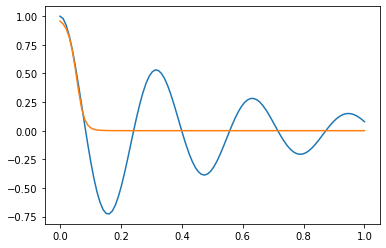

In [109]:

# hyperparameters
lr = 0.01  # learning rate
arch = [60,60,60,60] # architecture
epochs = 5000
loss_list = []
w_list = []

model = Model(arch)

# train model
for epoch in range(epochs):

    with tf.GradientTape() as g:
        ls, y_pred = model.loss(model(x_new), y)

    grads = g.gradient(ls, model.Variables)
    
    w_list.append(model.Variables[0][0][0])
    loss_list.append(ls)
    
    model.Variables = [v.assign_sub(delta * lr) for v, delta in zip(model.Variables, grads)]
    
    if epoch%(epochs // 10) == 0:
        print(f"epoch: {epoch:4d} \tloss: {ls:.5f} \t accuracy: {model.accuracy(y_pred, y)}")
#         print(f"y_pred = {y_pred} \tepoch: {epoch:4d} \tloss: {ls:.5f}")
        
print('\nfinal')
print(f"epoch: {epoch:4d} \tloss: {ls:.5f}")
# print(f"y_pred = {y_pred}")
plt.plot(x,y)
plt.plot(x,y_pred[0])
# plt.legend('actual', 'predicted')

In [39]:
class Model:
    def __init__(self, *arg):
        self.arch = arg[0]
        self.built = False # the model is called for first time
        
    
    """
    Init weight and biases for various layers of nodes
    args = no. of feature of X (in this case, 2)"""
    def build(self, input_len):
        print('Building NN model\n')
        w_init = tf.random.normal # alias for tf.random.normal
        b_init = tf.zeros         # alias for tf.zeros
        
        self.weights = []
        self.biases = []
        
        for dim in self.arch:
            self.weights.append(tf.Variable(
                w_init(shape=(dim, input_len))))
            self.biases.append(tf.Variable(
                b_init(shape=(dim, 1)))) ## 1 coz not a matrix
            
            input_len = dim
        
        # init wt and bias for final output layer [1 neuron]
        self.weights.append(tf.Variable(
            w_init(shape=(1, dim))))
        self.biases.append(tf.Variable(
            b_init(shape=(1,)))) # 1 coz not a matrix
        
        self.Variables = self.weights + self.biases
        
        ## change w_init to b_init for biases later
        
    """feedfwd process
    recieve X.shape = (2,4) -> 2 features, 4 samples
    return  y.shape = (1,4) -> 1 output, 4 samples
    """
    def __call__(self, X):
        if self.built == False:
            self.build(X.shape[0])
            self.built = True
        
        for w,b in zip(self.weights, self.biases):
            z = tf.matmul(w, X) + b
            a = tf.math.sigmoid(z)
            X = a
        
        return a
        
    
    def loss(self, y_pred, y_true):
        return tf.reduce_sum((y_pred - y_true)**2) / 4, y_pred 
    
    def accuracy(self, y_pred, y_true):
        # round off the prediction probabilities 
        new = tf.round(y_pred)
        # tf.equal() gives bool list for corresponding elements 
        # np.mean() calculates the mean of the bool list and gives accuracy in range 0-1
        return np.mean(tf.equal(y_true, new))
    
    def predict(self, X_input):
        output = model(X_input)
        new = tf.round(output)
        tf.print(new)


In [179]:
def progress_bar(progress, total):
    percent = (progress/float(total)) * 100
    bar = '#'*int(percent/2) + '-'*(50-int(percent/2))
    print(f"\r|{bar}|  {percent:.1f}%", end='\r')
        
for i in range(1000):
    time.sleep(0.000000001)
    progress_bar(i+1,1000)

In [ ]:
print('[--------------------------------------------------]')
dash = '-'
print(f'|{dash*50}|')

In [53]:
a = [10*i for i in range(10)]
for i,j in enumerate(a):
    print(i,j)

0 0
1 10
2 20
3 30
4 40
5 50
6 60
7 70
8 80
9 90


In [89]:
a = 10
print("a = " + f"{a}")

a = 10
